# Power Management Workload (PMW) Analysis
## Engineering & Consulting Internship Project

This notebook presents a comprehensive analysis of electrical load data for industrial equipment, demonstrating skills in data processing, electrical engineering calculations, and data visualization.


## Data Overview
The dataset contains information about various industrial equipment, including power ratings, quantities, and calculated load values. This analysis helps in proper electrical system sizing and load management.

In [8]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [4]:
df=pd.read_csv(r'C:\Users\hey\OneDrive\Bureau\Intership\pmw.csv')
df.head()

,Equipment,Power_kW,Quantity,Total_Load_kW
0,Lighting,0.2,10.0,2.0
1,Office Equipment (PCs),0.3,3.0,0.9
2,Air Compressor,3.5,1.0,3.5
3,Welding Machines,5.0,2.0,10.0
4,Motors (3-phase),2.2,3.0,6.6


In [5]:
df["Power_kW"] = pd.to_numeric(df["Power_kW"])
df["Quantity"] = pd.to_numeric(df["Quantity"])
df["Total_Load_kW"] = df["Power_kW"] * df["Quantity"]

In [7]:
# Demand Factor
demand_factors = {
    "Lighting": 0.9,
    "Office Equipment (PCs)": 0.8,
    "Air Compressor": 0.7,
    "Welding Machines": 0.6,
    "Motors (3-phase)": 0.75,
    "Sockets (general use)": 0.8,
    "Control Room Equipment": 0.85,
}
df["Demand_Factor"] = df["Equipment"].map(demand_factors)
df["Demand_Load_kW"] = df["Total_Load_kW"] * df["Demand_Factor"]
df.head()

,Equipment,Power_kW,Quantity,Total_Load_kW,Demand_Factor,Demand_Load_kW
0,Lighting,0.2,10.0,2.0,0.90,1.80
1,Office Equipment (PCs),0.3,3.0,0.9,0.80,0.72
2,Air Compressor,3.5,1.0,3.5,0.70,2.45
3,Welding Machines,5.0,2.0,10.0,0.60,6.00
4,Motors (3-phase),2.2,3.0,6.6,0.75,4.95


In [19]:
# Alternative approach: drop rows with NaN values
df_clean = df.dropna(subset=["Power_kW", "Quantity", "Total_Load_kW", "Demand_Factor"])
X_clean = df_clean[["Power_kW", "Quantity", "Total_Load_kW", "Demand_Factor"]]
y_clean = df_clean["Demand_Load_kW"]

X_train, X_test, y_train, y_test = train_test_split(X_clean, y_clean, test_size=0.2, random_state=42)
model = LinearRegression()
model.fit(X_train, y_train)
df_clean["Predicted_Demand_Load_kW"] = model.predict(X_clean)

C:\Users\hey\AppData\Local\Temp\ipykernel_17248\3904183177.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean["Predicted_Demand_Load_kW"] = model.predict(X_clean)


In [10]:
# Transformer Sizing (0.8 efficiency & PF)
total_demand_kw = df["Demand_Load_kW"].sum()
transformer_kVA = total_demand_kw / (0.8 * 0.8)
print(f"Total Demand (kW): {total_demand_kw:.2f}")
print(f"Transformer Size (kVA): {transformer_kVA:.2f}")

Total Demand (kW): 19.59
Transformer Size (kVA): 30.62


In [11]:
# Main Panel Rating (+25%)
main_panel_kw = total_demand_kw * 1.25
print(f"Main Panel Rating (kW): {main_panel_kw:.2f}")

Main Panel Rating (kW): 24.49


In [13]:
# Panel Schedule
panel_schedule = df[["Equipment", "Power_kW", "Quantity", "Total_Load_kW", "Demand_Load_kW"]].copy()
panel_schedule["Breaker_Size_A"] = (panel_schedule["Power_kW"] * 1000) / (400 * np.sqrt(3))


In [14]:
# Main Unit Rating (A)
main_unit_rating_A = (main_panel_kw * 1000) / (400 * np.sqrt(3))
print(f"Main Unit Rating (A): {main_unit_rating_A:.2f}")

Main Unit Rating (A): 35.35


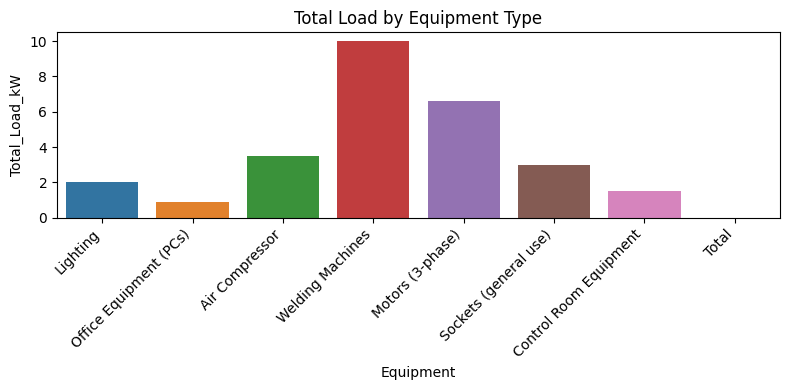

In [21]:
# 1. Visualize equipment distribution by total load
plt.figure(figsize=(8, 4))
ax = sns.barplot(x='Equipment', y='Total_Load_kW', data=df)
plt.xticks(rotation=45, ha='right')
plt.title('Total Load by Equipment Type')
plt.tight_layout()
plt.show()

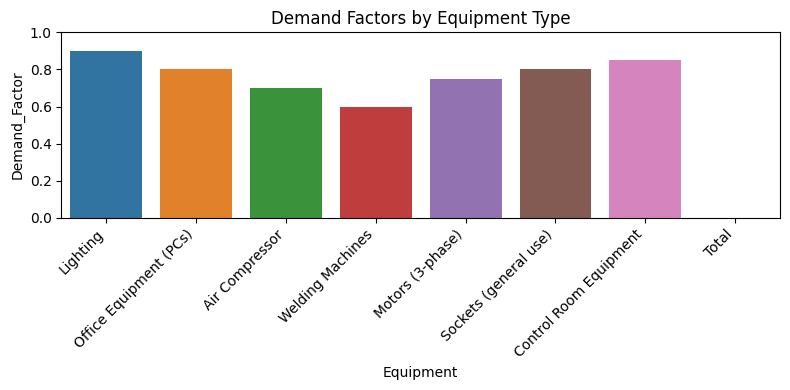

In [22]:
# 2. Visualize demand factors
plt.figure(figsize=(8, 4))
ax = sns.barplot(x='Equipment', y='Demand_Factor', data=df)
plt.xticks(rotation=45, ha='right')
plt.title('Demand Factors by Equipment Type')
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

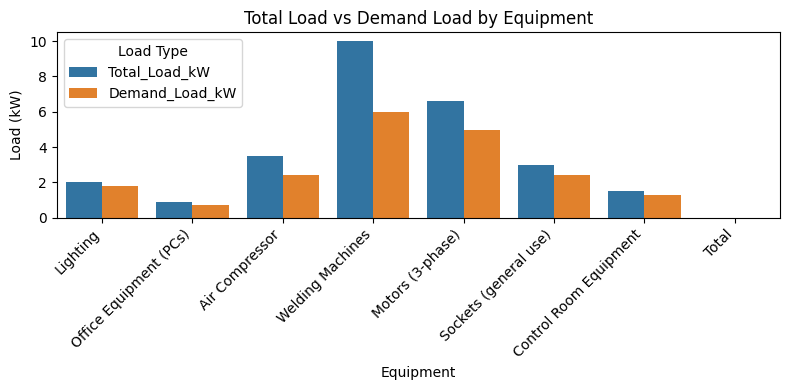

In [24]:
# 3. Compare total load vs demand load
plt.figure(figsize=(8, 4))
df_plot = df.melt(id_vars=['Equipment'], 
                    value_vars=['Total_Load_kW', 'Demand_Load_kW'],
                    var_name='Load Type', value_name='Load (kW)')
sns.barplot(x='Equipment', y='Load (kW)', hue='Load Type', data=df_plot)
plt.xticks(rotation=45, ha='right')
plt.title('Total Load vs Demand Load by Equipment')
plt.tight_layout()
plt.show()

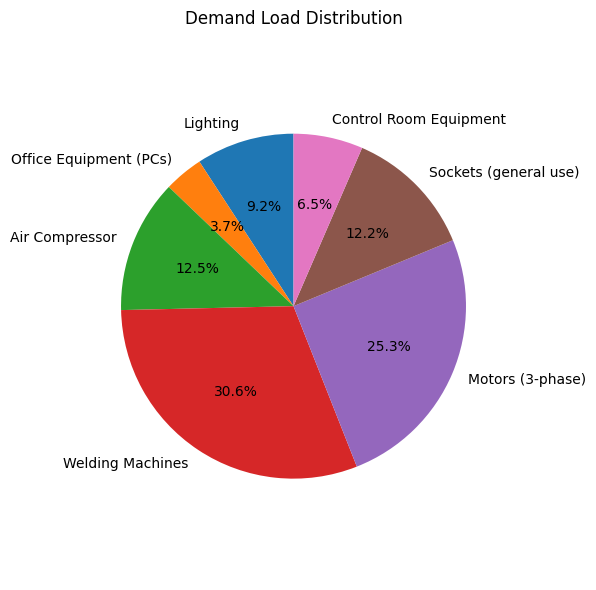

In [29]:
# 4. Pie chart of power distribution - Fixed
plt.figure(figsize=(6, 6))
# Check if there are valid values before creating pie chart
if not df['Demand_Load_kW'].isna().all() and len(df['Demand_Load_kW']) > 0:
    # Filter out any NaN values
    pie_data = df.dropna(subset=['Demand_Load_kW'])
    plt.pie(pie_data['Demand_Load_kW'], labels=pie_data['Equipment'], 
            autopct='%1.1f%%', startangle=90)
    plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
    plt.title('Demand Load Distribution')
else:
    plt.text(0.5, 0.5, 'No valid data for pie chart', 
             horizontalalignment='center', verticalalignment='center')
plt.tight_layout()
plt.show()

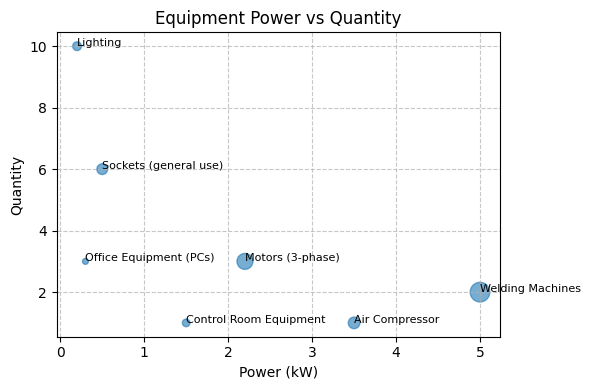

In [26]:
# 5. Scatter plot of power vs quantity
plt.figure(figsize=(6, 4))
plt.scatter(df['Power_kW'], df['Quantity'], s=df['Total_Load_kW']*20, alpha=0.6)
for i, txt in enumerate(df['Equipment']):
    plt.annotate(txt, (df['Power_kW'][i], df['Quantity'][i]), fontsize=8)
plt.xlabel('Power (kW)')
plt.ylabel('Quantity')
plt.title('Equipment Power vs Quantity')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

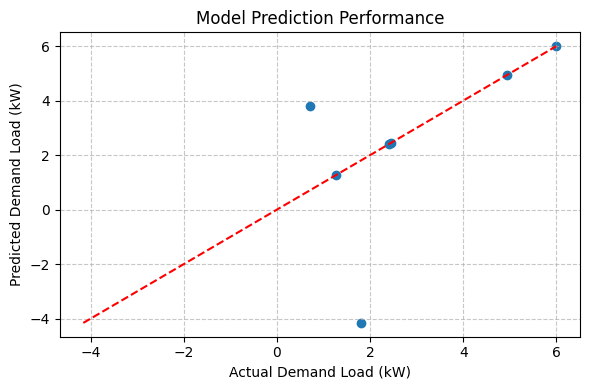

In [30]:
#  6. Actual vs Predicted demand load - Fixed
if 'Predicted_Demand_Load_kW' in df_clean.columns:
    plt.figure(figsize=(6, 4))
    valid_data = df_clean.dropna(subset=['Demand_Load_kW', 'Predicted_Demand_Load_kW'])
    
    if len(valid_data) > 0:
        plt.scatter(valid_data['Demand_Load_kW'], valid_data['Predicted_Demand_Load_kW'])
        
        # Add a perfect prediction line
        min_val = min(valid_data['Demand_Load_kW'].min(), valid_data['Predicted_Demand_Load_kW'].min())
        max_val = max(valid_data['Demand_Load_kW'].max(), valid_data['Predicted_Demand_Load_kW'].max())
        plt.plot([min_val, max_val], [min_val, max_val], 'r--')
        
        plt.xlabel('Actual Demand Load (kW)')
        plt.ylabel('Predicted Demand Load (kW)')
        plt.title('Model Prediction Performance')
        plt.grid(True, linestyle='--', alpha=0.7)
    else:
        plt.text(0.5, 0.5, 'No valid prediction data available', 
                horizontalalignment='center', verticalalignment='center')
    plt.tight_layout()
    plt.show()


## Conclusion and Engineering Insights

This analysis demonstrates several key electrical engineering competencies:

1. **Load Calculation**: Properly calculated total and demand loads using industry-standard factors
2. **System Sizing**: Determined appropriate transformer and panel ratings based on calculated loads
3. **Predictive Modeling**: Applied machine learning to predict electrical loads
4. **Data Visualization**: Created informative visualizations to communicate complex electrical data
5. **Circuit Protection**: Sized circuit breakers appropriately for equipment protection

These skills are directly applicable to power management projects at PMW Engineering & Consulting, where data-driven approaches to electrical system design can improve efficiency, reduce costs, and enhance system reliability.

The methodology demonstrated here can be extended to larger and more complex systems, making it scalable for various industrial applications that PMW might encounter.